## K-Means Clustering for California Housing Data

This notebook demonstrates how to use K-Means clustering, an unsupervised machine learning algorithm, to identify distinct geographical groups of houses based on their location and median value in California.

   longitude  latitude  median_house_value
0    -122.23     37.88            452600.0
1    -122.22     37.86            358500.0
2    -122.24     37.85            352100.0
3    -122.25     37.85            341300.0
4    -122.25     37.85            342200.0


<Axes: xlabel='longitude', ylabel='latitude'>

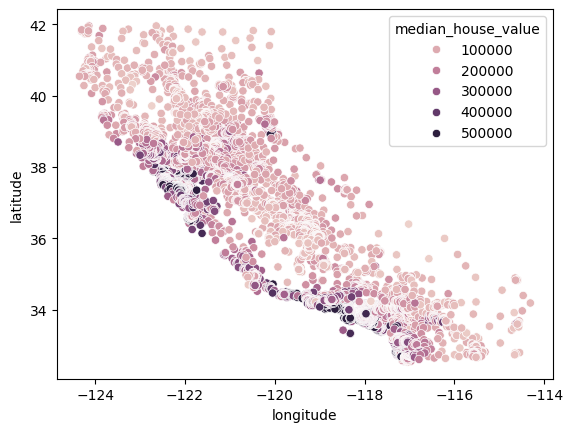

In [3]:
# Import necessary libraries for data handling and visualization
import pandas as pd  # Used for creating and manipulating dataframes
import seaborn as sns # Used for creating informative and attractive statistical graphics

# Import the california housing dataset
# The dataset is publicly available and a common benchmark for ML tasks.
# We use 'usecols' to only load the columns we need, which is more memory-efficient.
home_data = pd.read_csv('housing-Kaggle.csv', usecols = ['longitude', 'latitude', 'median_house_value'])

# Display the first 5 rows of the dataframe to get a quick overview of the data
print(home_data.head())

# Visualize the housing data using a scatter plot.
# We plot the location data (longitude vs. latitude).
# 'hue' is set to 'median_house_value' to color-code the points based on price.
# This creates a visual heatmap, showing how house prices are distributed geographically.
sns.scatterplot(data = home_data, x = 'longitude', y = 'latitude', hue = 'median_house_value')

### Data Preprocessing

Before applying the K-Means algorithm, we need to prepare the data. This involves:
1.  **Splitting the data** into training and testing sets to evaluate the model's performance on unseen data.
2.  **Normalizing the features** (`latitude` and `longitude`). Since K-Means is a distance-based algorithm, normalization ensures that all features contribute equally to the distance calculations, preventing features with larger scales from dominating.

In [4]:
# Import modules for data preprocessing and splitting from scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# We first set up training and test splits using train_test_split.
# The features (X) are the geographical coordinates.
# The target variable (y) is the median house value, which we'll use later for analysis.
# test_size=0.30 means 30% of the data is reserved for the test set.
# random_state=0 ensures that the split is the same every time the code is run, for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(home_data[['latitude', 'longitude']], home_data[['median_house_value']], test_size=0.30, random_state=0)

# Normalize the training and test data.
# The normalize function scales input vectors individually to have a unit norm (L2 norm by default).
# This is crucial for distance-based algorithms like K-Means.
X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)

### Finding the Optimal Number of Clusters (k) with the Elbow Method

The Elbow Method is a heuristic used to determine the optimal number of clusters in a dataset. We run K-Means for a range of `k` values and for each `k`, we calculate the Sum of Squared Errors (SSE), also known as inertia. We then plot SSE against `k`. The "elbow" on the plot, where the rate of SSE decrease sharply slows, suggests a good value for `k`.

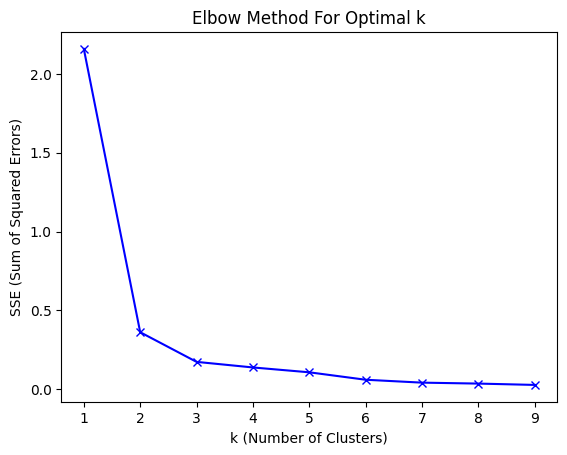

In [5]:
# Import the KMeans algorithm and the plotting library
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Initialize an empty list to store the Sum of Squared Errors (SSE) for each k
sse = []
# Define the range of k values to test, from 1 to 9
K = range(1, 10)

# Loop through each potential number of clusters
for k in K:
    # Create a KMeans instance and fit it to the normalized training data
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=0).fit(X_train_norm)
    # Append the SSE (inertia) of the fitted model to our list
    sse.append(kmeans.inertia_)

# Plot the Elbow curve: k vs. SSE
plt.plot(K, sse, 'bx-') # 'bx-' creates a blue line with 'x' markers at each data point
plt.xlabel('k (Number of Clusters)')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method For Optimal k')
plt.show() # Display the plot

### Fitting the Model and Evaluating Clusters

Based on the elbow plot, a `k` value between 3 and 6 seems reasonable. Let's start by arbitrarily choosing `k=3`, fit the model, and then evaluate the clusters using a scatter plot and a boxplot to see how well they separate the data both geographically and by price.

Silhouette Score for k=3: 0.7491460721562755


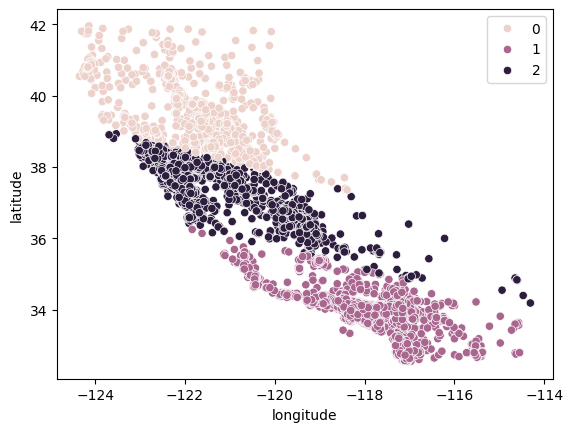

In [6]:
# Re-import KMeans (though not strictly necessary, it's good practice in separated cells)
from sklearn.cluster import KMeans
# Import silhouette_score for a quantitative measure of cluster quality
from sklearn.metrics import silhouette_score

# We will arbitrarily choose a number of clusters (k) of 3 to start.
# n_init='auto' is set to avoid a future warning and use the recommended setting.
# random_state=0 is for reproducibility of the initial centroid selection.
kmeans = KMeans(n_clusters = 3, random_state = 0, n_init='auto')

# Fit the model to the normalized training data
kmeans.fit(X_train_norm)

# Visualize the resulting clusters on a scatter plot.
# 'hue' is set to kmeans.labels_, which contains the cluster assignment for each data point.
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = kmeans.labels_)

# Calculate the Silhouette Score to evaluate the clustering quality.
# The score measures how well-defined the clusters are.
# A score close to 1 is good, close to 0 indicates overlapping clusters, and negative values suggest misclassification.
print(f"Silhouette Score for k=3: {silhouette_score(X_train_norm, kmeans.labels_, metric='euclidean')}")

<Axes: ylabel='median_house_value'>

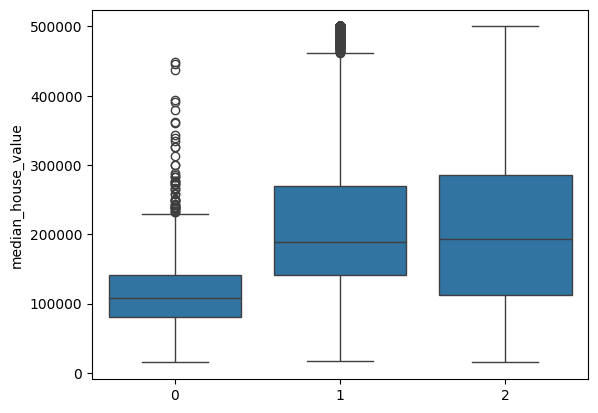

In [7]:
# Create a boxplot to see the distribution of median house prices within each of the 3 clusters.
# This helps in interpreting what each geographical cluster represents in terms of property value.
sns.boxplot(x = kmeans.labels_, y = y_train['median_house_value'])

### Hyperparameter Tuning: Exploring Different `k` Values

To make a more informed decision on the best `k`, we will now systematically fit models for different `k` values and compare their performance using the Silhouette Score. A higher silhouette score generally indicates better-defined clusters.

In [8]:
# Define a new range of k values to test, excluding k=1 as silhouette score is not defined for it.
K = range(2, 8)

# Initialize empty lists to store the fitted models and their corresponding silhouette scores
fits = []
silhouette_scores = []

# Loop through each value of k
for k in K:
    # Train the model for the current value of k on the normalized training data
    model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(X_train_norm)
    
    # Append the fitted model to the 'fits' list for later visualization
    fits.append(model)
    
    # Calculate the silhouette score for the current clustering and append it to the 'score' list
    silhouette_scores.append(silhouette_score(X_train_norm, model.labels_, metric='euclidean'))

### Visual Comparison of Different Clustering Results

<Axes: xlabel='longitude', ylabel='latitude'>

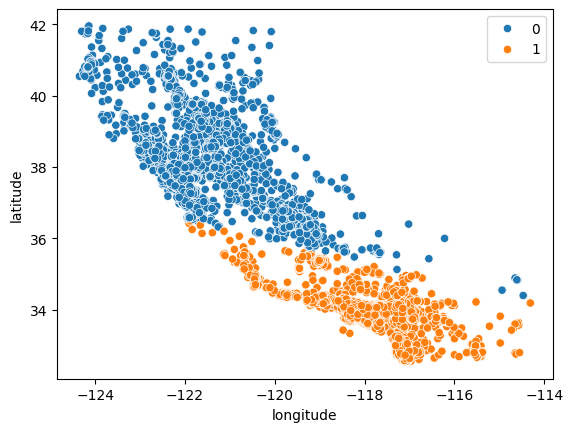

In [9]:
# Visualize the clusters for k=2.
# fits[0] corresponds to the model where k=2 (since our range started at 2).
# This split is very broad, likely representing Northern vs. Southern California.
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[0].labels_)

<Axes: xlabel='longitude', ylabel='latitude'>

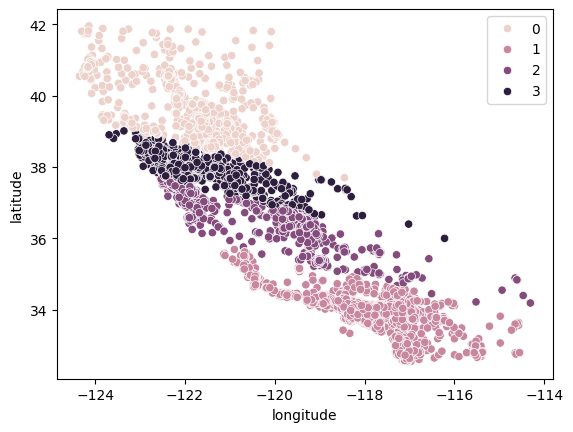

In [10]:
# Visualize the clusters for k=4.
# fits[2] corresponds to the model where k=4.
# This provides more nuance, potentially separating major metropolitan areas like LA, SF Bay Area, etc.
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[2].labels_)

<Axes: xlabel='longitude', ylabel='latitude'>

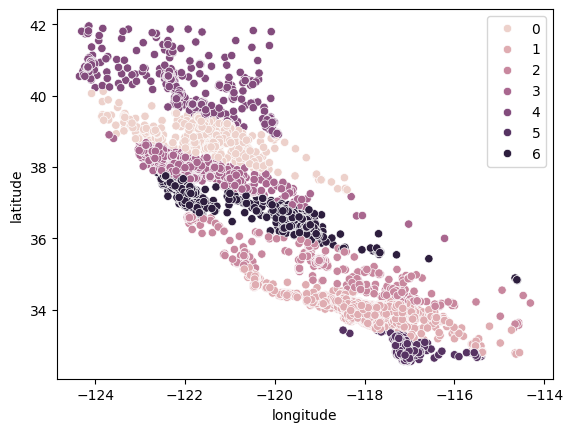

In [11]:
# Visualize the clusters for k=7.
# fits[5] corresponds to the model where k=7.
# This creates a more granular clustering. However, it might be overfitting,
# as the clusters become less distinct and harder to interpret.
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[5].labels_)

### Final Selection using Silhouette Score Plot

Let's plot the silhouette scores for each `k`. The value of `k` that gives the highest silhouette score is often considered the best choice.

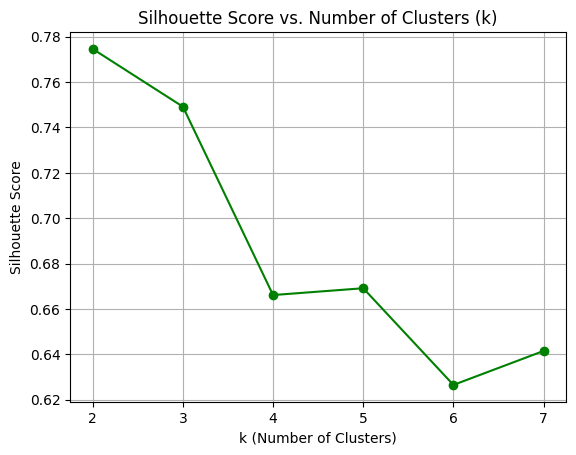

In [12]:
# Plot the silhouette scores against the number of clusters (k).
# This plot helps to quantitatively determine the optimal k.
# The peak of the plot indicates the k that results in the most dense and well-separated clusters.
plt.plot(range(2, 8), silhouette_scores, 'go-') # 'go-' creates a green line with circle markers
plt.xlabel('k (Number of Clusters)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters (k)')
plt.grid(True)
plt.show()

From the silhouette plot, **k=6** has the highest score, confirming our observation from the elbow plot that it's a good balance. Now, let's look at the price distribution for k=6.

<Axes: xlabel='longitude', ylabel='latitude'>

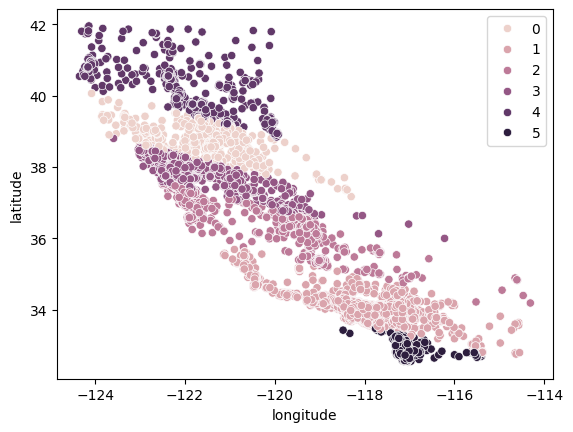

In [13]:
# Visualize the final chosen clustering with k=6.
# fits[4] corresponds to the model with k=6.
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[4].labels_)

<Axes: ylabel='median_house_value'>

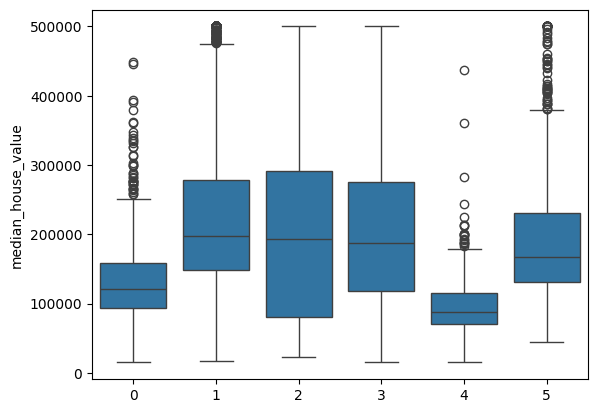

In [14]:
# Create a final boxplot for k=6 to analyze the median house value distribution in each of the six clusters.
# This gives a clear economic interpretation to our geographical clusters.
sns.boxplot(x = fits[4].labels_, y = y_train['median_house_value'])